In [1]:
from collections import namedtuple
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
tableau20 = [(r/255,g/255,b/255) for r,g,b in tableau20]

In [3]:
def read_scores(file_name):
    '''
    Read generated verification data from a csv file.

    Return: tuple of recorded errors and accuracies
    '''
    Errors = []
    Accs = []
    VerificationRecord = namedtuple('VerificationRecord', 'opt_error, accuracy')
    
    with open(file_name) as csvfile:
        readCSV = map(VerificationRecord._make, csv.reader(csvfile, delimiter=','))
        for row in readCSV:
            Errors.append(float(row.opt_error))
            Accs.append(float(row.accuracy))
    return (Errors, Accs)


def monotone_progress(Accs):
    maximum = 0
    monotoneValues = []
    for acc in Accs:
        maximum = maximum if acc < maximum else acc
        monotoneValues.append(maximum)
    return monotoneValues


def plot_overlap(ys, legends, title, ymin=0, ymax=None):

    fig = plt.figure(figsize=(5,5),facecolor='wheat', dpi=150)
    min_len = min([len(y) for y in ys])
    for i,y in enumerate(ys):
        y = y[:min_len]
        plt.plot(y, color=tableau20[i*2+1], alpha=0.7)
        
    for i,(y,leg) in enumerate(zip(ys, legends)):
        max_y = monotone_progress(y[:min_len])
        plt.plot(max_y, color=tableau20[i*2], label=leg)
    
    if not ymax:
        ymax = max([max(y) for y in ys]) + 0.0025
    plt.ylim(ymin, ymax)

    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Communication round")
    plt.legend(loc='lower right')
    
    pdf_path = "../benchmark_results/plot_" + title.replace(' ', '_') + ".pdf"
    plt.savefig(pdf_path, format='pdf')  
    plt.show(fig)
    
    
import re

def get_ceb(input_file_name):
    '''
    Matches and returns the integer preceded by "_id_"
    '''
    c_match = re.search(r'(?<=_C)\d+.\d+', input_file_name)
    c = float(c_match.group(0))
    e_match = re.search(r'(?<=_E)\d+', input_file_name)
    e = int(e_match.group(0))
    b_match = re.search(r'(?<=_B)\d+', input_file_name)
    b = int(b_match.group(0))
    return (c, e, b)

In [4]:
import glob

reg_file = '../benchmark_results/fedavg/non-iid/score_log_id*_MNIST-non-iid_C*_E*_B*_LR0.05_Decay1.0e-5.csv'

score_files = glob.glob(reg_file)
print(f"Found {len(score_files)} result files")

Found 12 result files


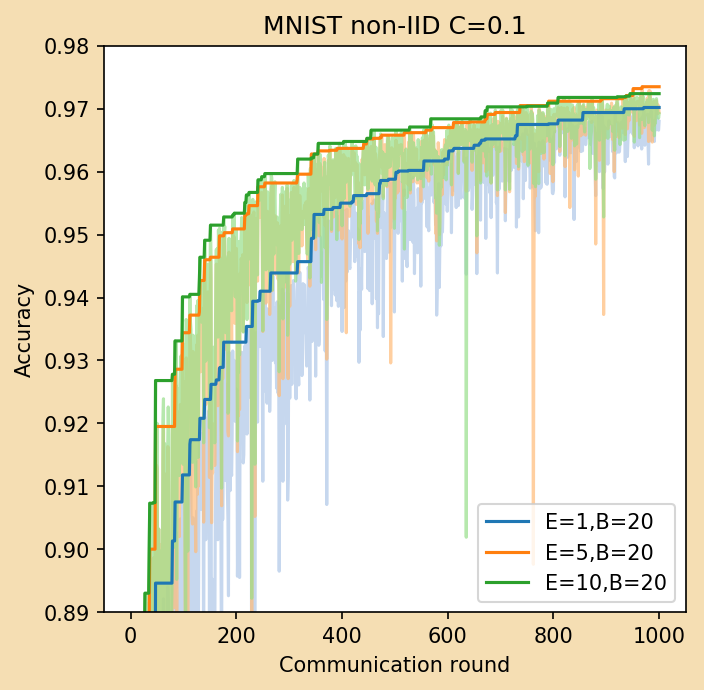

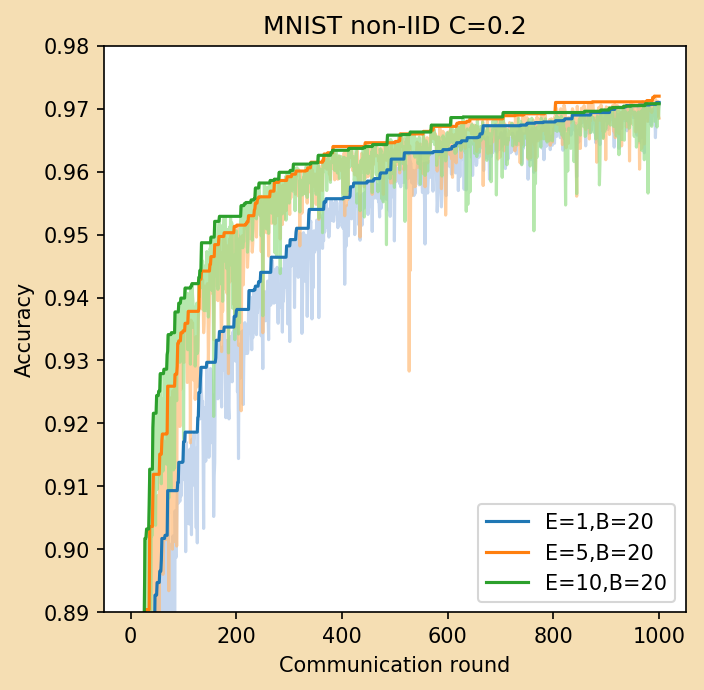

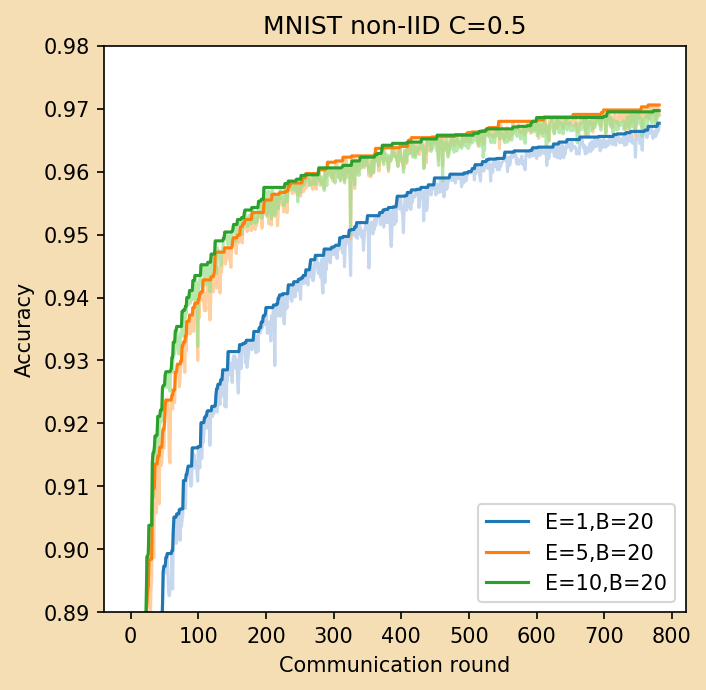

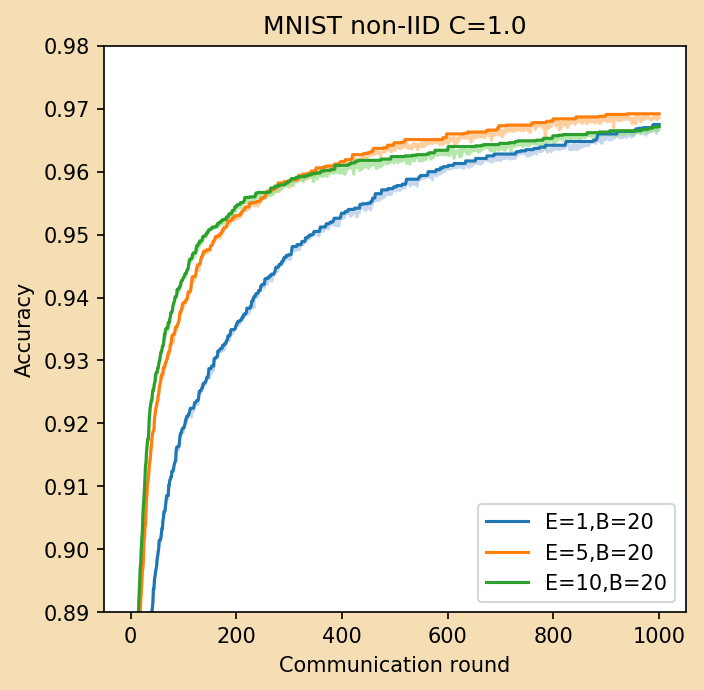

In [5]:
from itertools import groupby

ceb_values = [(get_ceb(file), file) for file in score_files]
ceb_values.sort()

for group, groups in groupby(ceb_values, lambda x: x[0][0]):
    accs = []
    legends = []
    for ((c, e, b), file) in groups:
        legends.append(f"E={e},B={b}")
        accs.append(read_scores(file)[1])
    title = f"MNIST non-IID C={group}"
    plot_overlap(accs, legends, title, ymin=0.89, ymax=0.98)